<a href="https://colab.research.google.com/github/FelipeLambach/workshop/blob/master/Lstm_01_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import CuDNNLSTM
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
data =pd.read_csv('gdrive/My Drive/Colab Notebooks/mastertable_inst17442_real_c20190730090438_f20181118001500_t20190717233000.csv',encoding='utf-8')
data.head()

,Unnamed: 0,energy,setpoint,minim_bool,setpoint_model_bool,temperatura,humidade_relativa,velocidade_vento,direcao_vento,weekday,hour,weekend,sunday,holiday,extended_holiday,work_bool,setpoint_min,setpoint_max,delta_setpoint,delta_min_outside,delta_max_outside,delta_outside_max
0,2018-11-18 00:15:00,17.0,22.06,False,True,14.88,90.5,33.48,134.25,6,0,True,True,False,False,False,16.0,28.0,12.0,1.12,13.12,-13.12
1,2018-11-18 00:30:00,17.0,22.06,False,True,14.85,91.0,33.85,135.50,6,0,True,True,False,False,False,16.0,28.0,12.0,1.15,13.15,-13.15
2,2018-11-18 00:45:00,16.0,22.06,False,True,14.82,91.5,34.22,136.75,6,0,True,True,False,False,False,16.0,28.0,12.0,1.18,13.18,-13.18
3,2018-11-18 01:00:00,17.0,22.06,False,True,14.80,92.0,34.60,138.00,6,1,True,True,False,False,False,16.0,28.0,12.0,1.20,13.20,-13.20
4,2018-11-18 01:15:00,17.0,22.06,False,True,14.82,92.0,34.22,141.75,6,1,True,True,False,False,False,16.0,28.0,12.0,1.18,13.18,-13.18


Convertendo variáveis booleanas para 0-1

In [0]:
data['minim_bool']=(data['minim_bool'] == True).astype(int)
data['setpoint_model_bool']=(data['setpoint_model_bool'] == True).astype(int)
data['weekend']=(data['weekend'] == True).astype(int)
data['sunday']=(data['sunday'] == True).astype(int)
data['holiday']=(data['holiday'] == True).astype(int)
data['extended_holiday']=(data['extended_holiday'] == True).astype(int)
data['work_bool']=(data['work_bool'] == True).astype(int)

Adicionando campo date para fazer group by por "Dia" 

In [5]:
def selectDay(x):
  return x.split(" ")[0]

data['date'] = data['Unnamed: 0'].apply(selectDay)

# def selectHour(x):
#   return x.split(" ")[1]


# data['hour'] = data['Unnamed: 0'].apply(selectHour)

# data = data.drop(['Unnamed: 0'], axis=1)


data['Unnamed: 0'] =  pd.to_datetime(data['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')

data.head()

,Unnamed: 0,energy,setpoint,minim_bool,setpoint_model_bool,temperatura,humidade_relativa,velocidade_vento,direcao_vento,weekday,hour,weekend,sunday,holiday,extended_holiday,work_bool,setpoint_min,setpoint_max,delta_setpoint,delta_min_outside,delta_max_outside,delta_outside_max,date
0,2018-11-18 00:15:00,17.0,22.06,0,1,14.88,90.5,33.48,134.25,6,0,1,1,0,0,0,16.0,28.0,12.0,1.12,13.12,-13.12,2018-11-18
1,2018-11-18 00:30:00,17.0,22.06,0,1,14.85,91.0,33.85,135.50,6,0,1,1,0,0,0,16.0,28.0,12.0,1.15,13.15,-13.15,2018-11-18
2,2018-11-18 00:45:00,16.0,22.06,0,1,14.82,91.5,34.22,136.75,6,0,1,1,0,0,0,16.0,28.0,12.0,1.18,13.18,-13.18,2018-11-18
3,2018-11-18 01:00:00,17.0,22.06,0,1,14.80,92.0,34.60,138.00,6,1,1,1,0,0,0,16.0,28.0,12.0,1.20,13.20,-13.20,2018-11-18
4,2018-11-18 01:15:00,17.0,22.06,0,1,14.82,92.0,34.22,141.75,6,1,1,1,0,0,0,16.0,28.0,12.0,1.18,13.18,-13.18,2018-11-18


Group by por dia


In [6]:
# Fazendo goupby day dos dados
groupList = list(data.groupby(['date'],as_index=False))
print("qdade days ",len(groupList))

qdade days  242


index dia da semana

In [9]:
weekday = []
for i in range(len(groupList)):
  weekday.append(groupList[i][1].iloc[0,0].weekday_name)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
def insert_row(row_number, df, row_value): 
    # Starting value of upper half 
  start_upper = 0
   
    # End value of upper half 
  end_upper = row_number 
   
  # Start value of lower half 
  start_lower = row_number 
   
  # End value of lower half 
  end_lower = df.shape[0] 
   
  # Create a list of upper_half index 
  upper_half = [*range(start_upper, end_upper, 1)] 
   
  # Create a list of lower_half index 
  lower_half = [*range(start_lower, end_lower, 1)] 
   
  # Increment the value of lower half by 1 
  lower_half = [x.__add__(1) for x in lower_half] 
   
  # Combine the two lists 
  index_ = upper_half + lower_half 
   
  # Update the index of the dataframe 
  df.index = index_ 
   
  # Insert a row at the end 
  df.loc[row_number] = row_value 
    
  # Sort the index labels 
  df = df.sort_index() 
   
  # return the dataframe 
  return df 

In [10]:
indexWeek = np.where(np.array(weekday)==weekday[206])
indexWeek[0]

array([  3,  10,  17,  24,  31,  38,  45,  52,  59,  66,  73,  80,  87,
        94, 101, 108, 115, 122, 129, 136, 143, 150, 157, 164, 171, 178,
       185, 192, 199, 206, 213, 220, 227, 234, 241])

In [13]:
 verifySequence([66, 67, 68, 80, 70, 71, 72, 73, 95])

([[66, 67, 68], [70, 71, 72, 73]], [80, 95])

In [0]:
# teste = [66, 67, 68, 80, 70, 71, 72, 73, 95]
# np.argwhere((np.isin(np.add(teste,1),teste)==True).flatten())

def verifySequence(idx_):
  """
    Verifica a existência de sequências faltantes
    parametros
      * idx_: index das horas faltantes
    return 
      * list: list com todos index da sequências de horas faltantes
      * listNotSeq: list com todos os index de horas faltantes que não sejam sequências 
  """
  posInitial = 0
  cont=0
  listSeq=[]
  listNotSeq=[]
  seq = []
  for i in range(1,len(idx_)):
    if idx_[i] == (idx_[i-1]+1): 
      # para guardar os dois primeiros index da sequência
      if cont==0:
#         print("primeira posicao ",i, idx_[i-1])
        seq.append(idx_[i-1])
        seq.append(idx_[i])
      else:
#         print("meio")
        seq.append(idx_[i])
      cont+=1
    else:
      if cont>0:
        listSeq.append(seq)
      else:
        listNotSeq.append(idx_[i-1])
      cont=0
      seq = []
    #verifica se é a ultima posicao para inserir a ultima seq
    if ((i == (len(idx_)-1)) & (cont>0)):
#       print("ultimo", (len(idx_)-1)," -- ",i)
      listSeq.append(seq)
    elif ((i == (len(idx_)-1)) & (cont==0)):
      listNotSeq.append(idx_[i])
  return listSeq,listNotSeq
    

In [17]:
sss=verifySameTemperature(241, [[66, 67, 68,70, 71, 72, 73]])
# bbbbb=verifySameTemperature(21, [[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],[66, 67, 68,70, 71, 72, 73]])


 ------------------------------------------ 
index  3
3
 seq faltante  [66, 67, 68, 70, 71, 72, 73]
seq  [66, 67, 68, 70, 71, 72, 73]
indexOtherWeek [14]
lacuna de interesse existente

 ------------------------------------------ 
index  10
10
 seq faltante  [66, 67, 68, 70, 71, 72, 73]
seq  [66, 67, 68, 70, 71, 72, 73]
indexOtherWeek []
lacuna de interesse existente

 ------------------------------------------ 
index  17
17
 seq faltante  [66, 67, 68, 70, 71, 72, 73]
seq  [66, 67, 68, 70, 71, 72, 73]
indexOtherWeek []
lacuna de interesse existente

 ------------------------------------------ 
index  24
24
 seq faltante  [66, 67, 68, 70, 71, 72, 73]
seq  [66, 67, 68, 70, 71, 72, 73]
indexOtherWeek [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
lacuna de interesse existente

 ------------------------------------------ 
index  31
31
 seq faltante  [66, 6

In [16]:
sss

NameError: ignored

In [0]:
import numpy as np

indexDay = 0
dataFrame= 1
freqDay = 96
groupListFormat=[]


def verifySameTemperature(indexWeek_, indexSeq_,windowns =4):
  
  """
    parameters
      * indexWeek_: index do dia da semana em que esta faltando sequencia de dias
      * indexSeq_: index das sequencias faltantes
    return
      
  """
  listWeek = np.where(np.array(weekday)==weekday[indexWeek_])
  
  indexDay = 0
  dataFrame= 1
  idxInf=0
  idxSup=1
  listResult=[]
  listAllSequence=[]
  for i in range(len(listWeek[0])):
    
    print("\n ------------------------------------------ ")
    print("index ", listWeek[0][i])
    #decarda a temperatuda da mesma data

      
    #cria um datatime com as datas corretas
    print(listWeek[0][i])
    date = groupList[listWeek[0][i]][indexDay]
    freqTime = pd.date_range(date, periods=freqDay, freq='15T')
    result = freqTime.isin((groupList[listWeek[0][i]][dataFrame].iloc[:,0]))

    # vertifica os indices faltantes no dia em outra semana i
    indexOtherWeek =np.argwhere(result==False).flatten()

    indexOtherWeek= indexOtherWeek.tolist()

    lengthDataOtherWeek = (len(groupList[listWeek[0][i]][dataFrame])-1)

#       print("index faltando nova semana ", indexOtherWeek)

#       offsetIndex= len(indexOtherWeek)

    j=0
    for seq in indexSeq_: 
      

      print(" seq faltante ",seq)
      #verifica se a lacuna faltante existe nesse dia
      if len(indexOtherWeek)<=0:
        verifyIndex=[False]
      else:
        verifyIndex = np.in1d(indexOtherWeek, seq)
      
      print("seq ",seq)
      print("indexOtherWeek",indexOtherWeek)

      # caso a lacuna existe
      if np.sum(verifyIndex)<=0:
        print("lacuna de interesse existente")

        minSeq = np.min(seq)
        maxSeq = np.max(seq)

        offsetIndexMin = np.sum(np.array(indexOtherWeek)<minSeq)
        offsetIndexMax = np.sum(np.array(indexOtherWeek)<maxSeq)

#           print("offsetIndexMin ",offsetIndexMin)
#           print("offsetIndexMax ",offsetIndexMax)

        # valores inferiores a lacuna faltante
#           print("lacuna Inferior")
        if len(indexOtherWeek)!=0:
            if indexOtherWeek[0]>minSeq:
              minIndex=minSeq-windowns
              if minIndex<0:
#                   print("inf nao existe caso 1")
#                   notExistsInf=[None]
                lacunaInf = [None]
              else:
#                   print(" existe caso 1 ")
                inf = np.subtract(seq,len(seq))
                notExistsInf = np.in1d(indexOtherWeek, inf )
#                   print(inf)
#                   print(indexOtherWeek)
#                   print("verif inf ",notExistsInf)
                if np.sum(notExistsInf==True)<=0:
#                     print(minIndex," -- ",minSeq)
                  lacunaInf = groupList[listWeek[0][i]][dataFrame].iloc[minIndex:minSeq,:]
                else:
#                     print("nao existe lacuna inferior")
                  lacunaInf = [None]

            else:
              minIndex= minSeq-windowns-offsetIndexMin
              if (minIndex)<0:
#                   print("existe caso 2")
#                   notExistsInf=[None]            
                lacunaInf = [None]
              else:
#                   print("else offset")
                inf = np.subtract(seq,len(seq))
                notExistsInf = np.in1d(indexOtherWeek, inf)
#                   print(inf)
#                   print(indexOtherWeek)
#                   print("verif inf ",notExistsInf)
                if np.sum(notExistsInf==True)<=0:
#                     print(minIndex," -- ",(minIndex+windowns))
                  lacunaInf = groupList[listWeek[0][i]][dataFrame].iloc[minIndex:(minIndex+windowns),:]
                else:
#                     print("nao existe lacuna inferior")
                  lacunaInf = [None]

        else:
#             print("existe caso 3")
          minIndex=minSeq
          inf =np.subtract(seq,len(seq))
          notExistsInf = np.in1d(indexOtherWeek, inf)

#             print(inf)
#             print(indexOtherWeek)
#             print("verif inf ",notExistsInf)
          if np.sum(notExistsInf==True)<=0:
#               print(minIndex," -- ",(minIndex+windowns))
            lacunaInf = groupList[listWeek[0][i]][dataFrame].iloc[(minIndex-windowns):minIndex,:]
          else:
#               print("nao existe lacuna inferior")
            lacunaInf = [None]


        #lacuna superior faltante
#           print(" Superior ")
        # valores inferiores a lacuna faltante
        if len(indexOtherWeek)!=0:
            if indexOtherWeek[0]>maxSeq:
              maxIndex=maxSeq+windowns
              if maxIndex>lengthDataOtherWeek:
#                   print(" nao existe caso 1")
                lacunaSup=[None]
              else:
#                   print("else sem offset")
                sup = np.add(seq,len(seq))
                notExistsSup = np.in1d(offsetIndex, sup)

#                   print(sup)
#                   print(indexOtherWeek)
#                   print("verif sup else ",notExistsSup)

                if np.sum(notExistsSup==True)<=0:
#                     print((maxIndex-windowns)," -- ",maxIndex)
                  lacunaSup = groupList[listWeek[0][i]][dataFrame].iloc[(maxIndex-windowns):maxIndex,:]
                else:
#                     print("nao existe lacuna superior")
                  lacunaSup = [None]

            else:
              maxIndex= maxSeq+windowns-offsetIndexMax+1
              if maxIndex>lengthDataOtherWeek:
#                   print("nao existe caso 2")
                lacunaSup=[None]            
              else:
#                   print("else offset")
                sup = np.add(seq,len(seq))
                notExistsSup = np.in1d(indexOtherWeek, sup)

#                   print(sup)
#                   print(indexOtherWeek)
#                   print("verif sup ",notExistsSup)
                if np.sum(notExistsSup==True)<=0:
#                     print((maxIndex-windowns)," -- ",maxIndex)
                  lacunaSup = groupList[listWeek[0][i]][dataFrame].iloc[(maxIndex-windowns):maxIndex,:]
                else:
#                     print("nao existe lacuna superior")
                  lacunaSup = [None]
        else:
#             print("existe caso 3")
          maxIndex=maxSeq+1
          sup = np.add(seq,len(seq))
          notExistsSup = np.in1d(indexOtherWeek, sup)

#             print(sup)
#             print(indexOtherWeek)
#             print("verif sup ",notExistsSup)
          if np.sum(notExistsSup==True)<=0:
#               print((maxIndex-windowns)," -- ",maxIndex)
            lacunaSup = groupList[listWeek[0][i]][dataFrame].iloc[maxIndex:(maxIndex+windowns),:]
          else:
#               print("nao existe lacuna superior")
            lacunaSup = [None]
          
        listResult.append([listWeek[0][i],lacunaInf,lacunaSup]) 
        j+=1
    
  listAllSequence.append(listResult)
  return listAllSequence

In [0]:
def convertParameters(df_):
  df_['minim_bool']=(df_['minim_bool'] == True).astype(int)
  df_['setpoint_model_bool']=(df_['setpoint_model_bool'] == True).astype(int)
  df_['weekend']=(df_['weekend'] == True).astype(int)
  df_['sunday']=(df_['sunday'] == True).astype(int)
  df_['holiday']=(df_['holiday'] == True).astype(int)
  df_['extended_holiday']=(df_['extended_holiday'] == True).astype(int)
  df_['work_bool']=(df_['work_bool'] == True).astype(int)
  df_ =df_.drop(['Unnamed: 0'], axis=1)
  df_=df_.drop(['date'], axis=1)
  
  return df_

In [0]:
def minsquareError(listData,indexTest,lacunaDayWeek):

  length = len(listData)
  data=[]
  print("size ",length)
  
  dataInf = convertParameters(lacunaDayWeek[0]).copy()
  dataSup = convertParameters(lacunaDayWeek[1]).copy()


  resultList = []
  
  for i in range(length):
    result = []
    erroInf=1000000
    erroSup=1000000
    indexErrorInf=-1
    indexErrorSup=-1
    for j in range(len(listData[i])):
      if listData[i][j][0]!=indexTest:

        inf = listData[i][j][1].copy()
        sup = listData[i][j][2].copy()

        try:
          if len(inf)>=0:
            inf=convertParameters(inf)
            
            auxErroInf = np.sum(np.absolute(dataInf.values-inf.values))
            if auxErroInf<erroInf:
              erroInf=auxErroInf
              indexErrorInf = listData[i][j][0]

          if len(sup)>=0:
            sup =convertParameters(sup)
            auxErroSup = np.sum(np.absolute(dataSup.values-sup.values))
            if auxErroSup<erroSup:
              erroSup=auxErroSup
              indexErrorSup = listData[i][j][0]

          result.append([listData[i][j][0],erroInf,erroSup])
        except Exception as e: 
          print("None ", e )
    print("inf ",erroInf," index ",indexErrorInf)
    print("sup ",erroSup, " index ",indexErrorSup)
    resultList.append(result)

    if erroInf>erroSup:
      data.append(indexErrorSup)
    else:
      data.append(indexErrorInf)
  return data  

In [0]:
eee = minsquareError(sss,241)

In [0]:
lacunaDayWeek(241,[[66, 67, 68,70, 71, 72, 73]])

In [0]:
def lacunaDayWeek(indexDayWeek,indexSeq_,window=4):
  print("lacunaDayWeek")
  indexDay=0
  dataFrame=1
  
  #cria um datatime com as datas corretas
  date = groupList[indexDayWeek][indexDay]
  freqTime = pd.date_range(date, periods=freqDay, freq='15T')
  resultRealDate = freqTime.isin((groupList[indexDayWeek][dataFrame].iloc[:,0]))

  # vertifica os indices faltantes na semana 
  indexWeek =np.argwhere(resultRealDate==False).flatten()

  indexWeek= indexWeek.tolist()
  
  result = []
  for seq in indexSeq_: 
    
      inf = np.subtract(seq,(len(seq)))
      inf = inf[((window+1)*-1):-1]
      sup = np.add(seq,len(seq))
      sup = sup[1:window+1]
      
      seqInferior = np.in1d(indexWeek, inf)
      seqSuperior = np.in1d(indexWeek, sup)
      
      # Sequencia inferior
      if np.sum(seqInferior==True)<=0 & inf[0]>=0:   
#         print("seq Inferior")
        minSeq = np.min(inf) 
        offsetIndexMin = np.sum(np.array(indexWeek)<minSeq)
        
        #add offset para corrigir posiçao do dataframe com horas faltantes
        if offsetIndexMin>0:
#           print("offset inferior")
          minSeq-=offsetIndexMin
        
        #verifica se o tamanho da seq-window é de um tamanho valido para o inicio do dataframe
        
        lacunaInf = groupList[indexDayWeek][dataFrame].iloc[(minSeq+1):(minSeq+window+1),:]
    
      else:
        lacunaInf = [None]
        print("nao existe coluna inferior")
      
      if (np.sum(seqSuperior==True)<=0) & (sup[window-1]<len(resultRealDate)):
#         print("seq Superior")
        maxSeq = np.max(sup)  
        offsetIndexMax = np.sum(np.array(indexWeek)<maxSeq)
        
        #add offset para corrigir posiçao do dataframe com horas faltantes
        if offsetIndexMax>0:
          maxSeq-=offsetIndexMax
        
        #verifica se o tamanho da seq-window é de um tamanho valido para o final do dataframe
        lacunaSup = groupList[indexDayWeek][dataFrame].iloc[maxSeq-window:maxSeq,:]
      else:
        lacunaSup = [None]
        print("nao existe coluna superior")        
    
      result.append([lacunaInf,lacunaSup])  
  return(result)

In [0]:
def interpolation(indexWeek,idx_, df_, threshold, windows_=2):
  
  windowns =4
  
  if len(df_) >= threshold:
    
    idxMax = np.argwhere((np.isin(np.add(idx_,windows_),idx_)==True).flatten())
    idxMin = np.argwhere((np.isin(np.subtract(idx_,windows_),idx_)==True).flatten())
    idxMax = idxMax.flatten()
    idxMin = idxMin.flatten()
    
    dfNew=pd.DataFrame(df_)
    
#     dfNew = dfNew.drop(['Unnamed: 0'], axis=1)
#     dfNew = dfNew.drop(['date'], axis=1)
    
    # para ajustar os indices corretos para fazer a interpolacao do dataframe original
    offset=0
    if idxMax.any() & idxMin.any():
      print(" ---------------- Dados Sequenciais Faltando ---------------------------------- ")
      
      
      
      listSeq,listNotSeq = verifySequence(idx_)
      
      listSeq = np.array(listSeq)
      print("listSeq ",listSeq)
      print("indexWeek ",indexWeek)
      result = verifySameTemperature(indexWeek, listSeq)
      
      print("tamanho de sequencia" , len(result))
      
      intervalDayWeek = lacunaDayWeek(indexWeek,listSeq,window=4)
      
      calcula_minError =  minsquareError(result,indexWeek,intervalDayWeek[0])
      
      print("add sequencias")
      
    else:
      for i in idx_:
        #se estiver faltando dado na primeira posicao do dataframe
        print(" index = ",i , " ----- index original ",(i-offset))
        if (i-offset)-windows_<0:
          print("Primeira Posicao")
          aux = df_.iloc[0:windows_,:].mean()
        #se estiver faltando a ultima posicao do dataframe
        elif (i-offset)+windows_ > (len(df_)-1):
          print("Ultima Posicao")
          print("size dataframe",(len(df_)-1))
          print("i-windows = ",(len(df_)-1)-windows_, " i ",(len(df_)-1))
          aux = df_.iloc[(len(df_)-1)-windows_:(len(df_)-1),:].mean()
        else:
          print("Meio")
          aux = df_.iloc[((i-offset)-offset)-windows_:((i-offset)-offset)+windows_,:].mean()
        offset+=1
        dfNew = insert_row(i, dfNew, aux)
        
  else:
    print("descartado")
    return 0
  
  return dfNew
 

In [0]:
listSeq,listNotSeq = verifySequence([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 57, 58, 59, 60, 62, 63, 64, 65, 66, 68])
print(listSeq)
print(listNotSeq)

In [183]:
fff =interpolation(241,[66 ,67 ,68 ,69 ,70 ,71 ,72 ,73], groupList[241][dataFrame],80)

 ---------------- Dados Sequenciais Faltando ---------------------------------- 
listSeq  [[66 67 68 69 70 71 72 73]]
indexWeek  241

 ------------------------------------------ 
index  3
3
 seq faltante  [66 67 68 69 70 71 72 73]
seq  [66 67 68 69 70 71 72 73]
indexOtherWeek [14]
lacuna de interesse existente

 ------------------------------------------ 
index  10
10
 seq faltante  [66 67 68 69 70 71 72 73]
seq  [66 67 68 69 70 71 72 73]
indexOtherWeek []
lacuna de interesse existente

 ------------------------------------------ 
index  17
17
 seq faltante  [66 67 68 69 70 71 72 73]
seq  [66 67 68 69 70 71 72 73]
indexOtherWeek []
lacuna de interesse existente

 ------------------------------------------ 
index  24
24
 seq faltante  [66 67 68 69 70 71 72 73]
seq  [66 67 68 69 70 71 72 73]
indexOtherWeek [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

inf  114.04333333333332  index  185
sup  95.63733333333339  index  178
add sequencias


In [0]:
groupList[154][dataFrame].reset_index()

,index,Unnamed: 0,energy,setpoint,minim_bool,setpoint_model_bool,temperatura,humidade_relativa,velocidade_vento,direcao_vento,weekday,hour,weekend,sunday,holiday,extended_holiday,work_bool,setpoint_min,setpoint_max,delta_setpoint,delta_min_outside,delta_max_outside,delta_outside_max,date
0,0,2019-04-21 00:00:00,17.0,21.370000,False,True,14.10,80.00,6.70,136.00,6,0,True,True,True,True,False,16.0,28.0,12.0,1.90,13.90,-13.90,2019-04-21
1,1,2019-04-21 00:15:00,16.0,21.370000,False,True,14.15,79.50,7.00,134.25,6,0,True,True,True,True,False,16.0,28.0,12.0,1.85,13.85,-13.85,2019-04-21
2,3,2019-04-21 00:45:00,16.0,21.370000,False,True,14.25,78.50,7.60,130.75,6,0,True,True,True,True,False,16.0,28.0,12.0,1.75,13.75,-13.75,2019-04-21
3,4,2019-04-21 01:00:00,16.0,21.370000,False,True,14.30,78.00,7.90,129.00,6,1,True,True,True,True,False,16.0,28.0,12.0,1.70,13.70,-13.70,2019-04-21
4,5,2019-04-21 01:15:00,17.0,21.370000,False,True,14.30,76.50,8.60,127.00,6,1,True,True,True,True,False,16.0,28.0,12.0,1.70,13.70,-13.70,2019-04-21
5,6,2019-04-21 01:30:00,16.0,21.370000,False,True,14.30,75.00,9.30,125.00,6,1,True,True,True,True,False,16.0,28.0,12.0,1.70,13.70,-13.70,2019-04-21
6,7,2019-04-21 01:45:00,16.0,21.370000,False,True,14.30,73.50,10.00,123.00,6,1,True,True,True,True,False,16.0,28.0,12.0,1.70,13.70,-13.70,2019-04-21
7,8,2019-04-21 02:00:00,16.0,21.370000,False,True,14.30,72.00,10.70,121.00,6,2,True,True,True,True,False,16.0,28.0,12.0,1.70,13.70,-13.70,2019-04-21
8,9,2019-04-21 02:30:00,17.0,21.370000,False,True,14.10,70.00,11.70,118.50,6,2,True,True,True,True,False,16.0,28.0,12.0,1.90,13.90,-13.90,2019-04-21
9,10,2019-04-21 02:45:00,15.0,21.370000,False,True,14.00,69.00,12.20,117.25,6,2,True,True,True,True,False,16.0,28.0,12.0,2.00,14.00,-14.00,2019-04-21


In [0]:
date1 = groupList[154][indexDay]
freqTime1 = pd.date_range(date1, periods=freqDay, freq='15T')
  
ee = groupList[154][dataFrame].iloc[:,0].isin(freqTime1)
  
ff = np.argwhere(ee==False).flatten()
ff

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


array([], dtype=int64)

In [0]:
 np.argwhere((freqTime1.isin((groupList[154][dataFrame].iloc[:,0]))==False)).flatten()

array([ 2,  9, 13, 19, 78, 79, 81, 83, 85, 92])

Ajustando a serie para amostras para 15 minutos

In [0]:


for i in range(0,len(groupList)):
  date = groupList[i][indexDay]
  freqTime = pd.date_range(date, periods=freqDay, freq='15T')
  result = freqTime.isin((groupList[i][dataFrame].iloc[:,0]))
  #verifica se existe a frequencia de dados é igual a freqDay
#   print(result.sum()<freqDay )
  if result.sum()<freqDay:
    print(" index ",i)
    index =np.argwhere(result==False).flatten()
    print(index.tolist())
    
    interpolation(index, groupList[i][dataFrame],80)
    
    groupListFormat.append((groupList[i][indexDay],groupList[i][dataFrame]))
  

 index  0
[0]
 index =  0  ----- index original  0
Primeira Posicao
 index  1
[9]
 index =  9  ----- index original  9
Meio
 index  3
[14]
 index =  14  ----- index original  14
Meio
 index  5
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
descartado
 index  8
[18]
 index =  18  ----- index original  18
Meio
 index  12
[43]
 index =  43  ----- index original  43
Meio
 index  13
[20, 92]
 index =  20  ----- index original  20
Meio
 index =  92  ----- index original  91
Meio
 index  14
[12]
 index =  12  ----- index original  12
Meio
 index  18
[23]
 index =  23  ----- index original  23
Meio
 index  20
[27]
 index =  27  ----- index original  27
Meio
 index  21
[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 57, 58, 59, 60, 62, 63, 64, 65, 66, 68]
descartado
 index  23
[73, 74, 75, 76, 77, 78, 79, 85,

In [0]:
groupList[241][dataFrame]

,Unnamed: 0,energy,setpoint,minim_bool,setpoint_model_bool,temperatura,humidade_relativa,velocidade_vento,direcao_vento,weekday,hour,weekend,sunday,holiday,extended_holiday,work_bool,setpoint_min,setpoint_max,delta_setpoint,delta_min_outside,delta_max_outside,delta_outside_max,date
22471,2019-07-17 00:00:00,18.0,21.670000,0,1,17.70,85.00,24.10,334.00,2,0,0,0,0,0,0,16.0,28.0,12.0,-1.70,10.30,-10.30,2019-07-17
22472,2019-07-17 00:15:00,18.0,21.670000,0,1,17.75,84.75,23.68,334.75,2,0,0,0,0,0,0,16.0,28.0,12.0,-1.75,10.25,-10.25,2019-07-17
22473,2019-07-17 00:30:00,18.0,21.670000,0,1,17.80,84.50,23.25,335.50,2,0,0,0,0,0,0,16.0,28.0,12.0,-1.80,10.20,-10.20,2019-07-17
22474,2019-07-17 00:45:00,17.0,21.670000,0,1,17.85,84.25,22.82,336.25,2,0,0,0,0,0,0,16.0,28.0,12.0,-1.85,10.15,-10.15,2019-07-17
22475,2019-07-17 01:00:00,18.0,21.670000,0,1,17.90,84.00,22.40,337.00,2,1,0,0,0,0,0,16.0,28.0,12.0,-1.90,10.10,-10.10,2019-07-17
22476,2019-07-17 01:15:00,17.0,21.670000,0,1,17.88,84.00,22.00,337.00,2,1,0,0,0,0,0,16.0,28.0,12.0,-1.88,10.12,-10.12,2019-07-17
22477,2019-07-17 01:30:00,17.0,21.670000,0,1,17.85,84.00,21.60,337.00,2,1,0,0,0,0,0,16.0,28.0,12.0,-1.85,10.15,-10.15,2019-07-17
22478,2019-07-17 01:45:00,17.0,21.670000,0,1,17.82,84.00,21.20,337.00,2,1,0,0,0,0,0,16.0,28.0,12.0,-1.82,10.18,-10.18,2019-07-17
22479,2019-07-17 02:00:00,18.0,21.670000,0,1,17.80,84.00,20.80,337.00,2,2,0,0,0,0,0,16.0,28.0,12.0,-1.80,10.20,-10.20,2019-07-17
22480,2019-07-17 02:15:00,17.0,21.670000,0,1,17.80,84.00,20.45,336.50,2,2,0,0,0,0,0,16.0,28.0,12.0,-1.80,10.20,-10.20,2019-07-17


In [0]:
teste = np.argwhere(freqTime.isin((groupList[49][dataFrame].iloc[:,0]))==False).flatten()

In [0]:
np.argwhere((np.isin(teste, teste+10)==True).flatten())
a = np.argwhere((np.isin(teste, teste-10)==True).flatten())
a

array([[0]])

In [0]:
aa = np.argwhere((np.isin(teste, teste+10)==True).flatten())

In [0]:
aa.flatten()

array([1])

In [0]:
aa = [15,54,2,23,12]
b =np.argwhere((np.isin(np.add(aa,2),aa)==True).flatten())
b = b.flatten()
b

array([], dtype=int64)

In [0]:
if b.any():
  print("nao vazio")
else:
  print("vazio")
b.any()

vazio


False

In [0]:
b.flatten().tolist()

[1]

In [0]:
teste

array([[ 6],
       [16],
       [27],
       [90]])

In [0]:
# np.any(teste == (teste+2))
[teste+2 in teste] == True 

False

In [0]:
np.argwhere(freqTime.isin((groupList[49][dataFrame].iloc[:,0]))==False).tolist()

[[6], [16], [27], [90]]

In [0]:
groupList[i][dataFrame]

,Unnamed: 0,energy,setpoint,minim_bool,setpoint_model_bool,temperatura,humidade_relativa,velocidade_vento,direcao_vento,weekday,hour,weekend,sunday,holiday,extended_holiday,work_bool,setpoint_min,setpoint_max,delta_setpoint,delta_min_outside,delta_max_outside,delta_outside_max,date
4274,2019-01-06 00:00:00,16.0,21.700000,False,True,6.60,78.00,7.80,35.00,6,0,True,True,False,False,False,16.0,28.0,12.0,9.40,21.40,-21.40,2019-01-06
4275,2019-01-06 00:15:00,16.0,21.700000,False,True,6.65,78.75,7.38,38.75,6,0,True,True,False,False,False,16.0,28.0,12.0,9.35,21.35,-21.35,2019-01-06
4276,2019-01-06 00:30:00,16.0,21.700000,False,True,6.70,79.50,6.95,42.50,6,0,True,True,False,False,False,16.0,28.0,12.0,9.30,21.30,-21.30,2019-01-06
4277,2019-01-06 00:45:00,16.0,21.700000,False,True,6.75,80.25,6.52,46.25,6,0,True,True,False,False,False,16.0,28.0,12.0,9.25,21.25,-21.25,2019-01-06
4278,2019-01-06 01:00:00,16.0,21.700000,False,True,6.80,81.00,6.10,50.00,6,1,True,True,False,False,False,16.0,28.0,12.0,9.20,21.20,-21.20,2019-01-06
4279,2019-01-06 01:15:00,16.0,21.700000,False,True,6.65,81.00,5.98,51.25,6,1,True,True,False,False,False,16.0,28.0,12.0,9.35,21.35,-21.35,2019-01-06
4280,2019-01-06 01:45:00,16.0,21.700000,False,True,6.35,81.00,5.72,53.75,6,1,True,True,False,False,False,16.0,28.0,12.0,9.65,21.65,-21.65,2019-01-06
4281,2019-01-06 02:00:00,16.0,21.700000,False,True,6.20,81.00,5.60,55.00,6,2,True,True,False,False,False,16.0,28.0,12.0,9.80,21.80,-21.80,2019-01-06
4282,2019-01-06 02:15:00,17.0,21.700000,False,True,6.40,81.50,5.48,54.75,6,2,True,True,False,False,False,16.0,28.0,12.0,9.60,21.60,-21.60,2019-01-06
4283,2019-01-06 02:30:00,16.0,21.700000,False,True,6.60,82.00,5.35,54.50,6,2,True,True,False,False,False,16.0,28.0,12.0,9.40,21.40,-21.40,2019-01-06


In [0]:
groupList[i][dataFrame]

,Unnamed: 0,energy,setpoint,minim_bool,setpoint_model_bool,temperatura,humidade_relativa,velocidade_vento,direcao_vento,weekday,hour,weekend,sunday,holiday,extended_holiday,work_bool,setpoint_min,setpoint_max,delta_setpoint,delta_min_outside,delta_max_outside,delta_outside_max,date
4274,2019-01-06 00:00:00,16.0,21.700000,False,True,6.60,78.00,7.80,35.00,6,0,True,True,False,False,False,16.0,28.0,12.0,9.40,21.40,-21.40,2019-01-06
4275,2019-01-06 00:15:00,16.0,21.700000,False,True,6.65,78.75,7.38,38.75,6,0,True,True,False,False,False,16.0,28.0,12.0,9.35,21.35,-21.35,2019-01-06
4276,2019-01-06 00:30:00,16.0,21.700000,False,True,6.70,79.50,6.95,42.50,6,0,True,True,False,False,False,16.0,28.0,12.0,9.30,21.30,-21.30,2019-01-06
4277,2019-01-06 00:45:00,16.0,21.700000,False,True,6.75,80.25,6.52,46.25,6,0,True,True,False,False,False,16.0,28.0,12.0,9.25,21.25,-21.25,2019-01-06
4278,2019-01-06 01:00:00,16.0,21.700000,False,True,6.80,81.00,6.10,50.00,6,1,True,True,False,False,False,16.0,28.0,12.0,9.20,21.20,-21.20,2019-01-06
4279,2019-01-06 01:15:00,16.0,21.700000,False,True,6.65,81.00,5.98,51.25,6,1,True,True,False,False,False,16.0,28.0,12.0,9.35,21.35,-21.35,2019-01-06
4280,2019-01-06 01:45:00,16.0,21.700000,False,True,6.35,81.00,5.72,53.75,6,1,True,True,False,False,False,16.0,28.0,12.0,9.65,21.65,-21.65,2019-01-06
4281,2019-01-06 02:00:00,16.0,21.700000,False,True,6.20,81.00,5.60,55.00,6,2,True,True,False,False,False,16.0,28.0,12.0,9.80,21.80,-21.80,2019-01-06
4282,2019-01-06 02:15:00,17.0,21.700000,False,True,6.40,81.50,5.48,54.75,6,2,True,True,False,False,False,16.0,28.0,12.0,9.60,21.60,-21.60,2019-01-06
4283,2019-01-06 02:30:00,16.0,21.700000,False,True,6.60,82.00,5.35,54.50,6,2,True,True,False,False,False,16.0,28.0,12.0,9.40,21.40,-21.40,2019-01-06


In [0]:
teste.isin((groupList[49][1].iloc[:,0]))

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True])

In [0]:
groupList()

AttributeError: ignored

qdade days  242


#### Exluindo dias com ***setpoint*** nulo

In [0]:
qdadenull=0
for i in range(0,len(groupList)-1):
  aux = groupList[i][1]
  result = pd.DataFrame(aux.isnull().values)
  nan = result.iloc[:,1].sum()
  if nan>0:
    qdadenull+=1
    print("index day ",i, "  qdade nan = ",nan)

In [0]:
for i in range(qdadenull):
  del groupList[186]

In [0]:
for i in range(0,len(groupList)-1):
  aux = groupList[i][1]
  result = pd.DataFrame(aux.isnull().values)
  nan = result.iloc[:,1].sum()
  if nan>0:
    print("index day ",i, "  qdade nan = ",nan)

#### Verificando o padrão dos horários do dia

In [0]:
print("qdade days ",len(groupList))

qdade days  242


In [0]:
# print(fifteen.hour , fifteen.minute , fifteen/.second)
date_time_obj = datetime.datetime.strptime(data['Unnamed: 0'][0], '%Y-%m-%d %H:%M:%S')

date_time_obj.time

<function datetime.time>

In [0]:
newline={"Unnamed: 0":None,	"energy":None,	"setpoint":None,	"minim_bool":None,	"setpoint_model_bool":None,	"temperatura":None,	"humidade_relativa":None, \
         "velocidade_vento":None,	"direcao_vento":None,	"weekday":None,	"hour":None,	"weekend":None,	"sunday":None,	"holiday":None,	"extended_holiday":None, \
         "work_bool":None,	"setpoint_min":None , "setpoint_max":None,	"delta_setpoint":None,	"delta_min_outside":None,	"delta_max_outside":None,
         "delta_outside_max":None, "date":None}

In [0]:
import datetime
from datetime import timedelta  

listInfo=[]
for i in range(len(groupList)):#len(groupList)-1
  print(" -------------------------------- \n --------- ",i)
  
  date_Compare = datetime.datetime(2019, 5,17,0,0,0)
  cont=0
  if len(groupList[i][1]["Unnamed: 0"])>=sizeHour:
    for j in range(sizeHour):
      date_time_obj = datetime.datetime.strptime(groupList[i][1]["Unnamed: 0"].iloc[j], '%Y-%m-%d %H:%M:%S')
      print("line ",j,"  ",date_Compare.time() , " == ",date_time_obj.time())
      if date_Compare.time() == date_time_obj.time():
        pass
        print("equals")
      else:
        
#         line = pd.DataFrame(newline, index=[j])
#         groupList[i][1] = pd.concat([groupList[i][1].iloc[:j-1], line, groupList[i][1].iloc[j:]]).reset_index(drop=True)
        cont+=1
        print("add list")
      
      date_Compare+=timedelta(minutes=15)
      
  listInfo.append(cont)
        
#       print(j, " ---- " ,groupList[i][1]["Unnamed: 0"].iloc[j])
  
# fifteen = x+timedelta(minutes=15)  
# # fifteenAgo = x.subtract(15)
# print(x)
# print(fifteen)

 -------------------------------- 
 ---------  0
line  0    00:00:00  ==  00:15:00
add list
line  1    00:15:00  ==  00:30:00
add list
line  2    00:30:00  ==  00:45:00
add list
line  3    00:45:00  ==  01:00:00
add list
line  4    01:00:00  ==  01:15:00
add list
line  5    01:15:00  ==  01:30:00
add list
line  6    01:30:00  ==  01:45:00
add list
line  7    01:45:00  ==  02:00:00
add list
line  8    02:00:00  ==  02:15:00
add list
line  9    02:15:00  ==  02:30:00
add list
line  10    02:30:00  ==  02:45:00
add list
line  11    02:45:00  ==  03:00:00
add list
line  12    03:00:00  ==  03:15:00
add list
line  13    03:15:00  ==  03:30:00
add list
line  14    03:30:00  ==  03:45:00
add list
line  15    03:45:00  ==  04:00:00
add list
line  16    04:00:00  ==  04:15:00
add list
line  17    04:15:00  ==  04:30:00
add list
line  18    04:30:00  ==  04:45:00
add list
line  19    04:45:00  ==  05:00:00
add list
line  20    05:00:00  ==  05:15:00
add list
line  21    05:15:00  ==  05:30:00
ad

In [0]:
aux=0
for i in range(len(listInfo)):
  if listInfo[i]>0:
    aux+=1
aux

47

In [0]:
pd.concat([ line, groupList[i][1].iloc[3:]]).reset_index(drop=True)
# groupList[i][1]

,Unnamed: 0,energy,setpoint,minim_bool,setpoint_model_bool,temperatura,humidade_relativa,velocidade_vento,direcao_vento,weekday,hour,weekend,sunday,holiday,extended_holiday,work_bool,setpoint_min,setpoint_max,delta_setpoint,delta_min_outside,delta_max_outside,delta_outside_max,date
0,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None
1,2018-11-18 01:00:00,17.0,22.060000,0,1,14.80,92.00,34.60,138.00,6,1,1,1,0,0,0,16.0,28.0,12.0,1.20,13.20,-13.20,2018-11-18
2,2018-11-18 01:15:00,17.0,22.060000,0,1,14.82,92.00,34.22,141.75,6,1,1,1,0,0,0,16.0,28.0,12.0,1.18,13.18,-13.18,2018-11-18
3,2018-11-18 01:30:00,17.0,22.060000,0,1,14.85,92.00,33.85,145.50,6,1,1,1,0,0,0,16.0,28.0,12.0,1.15,13.15,-13.15,2018-11-18
4,2018-11-18 01:45:00,16.0,22.060000,0,1,14.88,92.00,33.48,149.25,6,1,1,1,0,0,0,16.0,28.0,12.0,1.12,13.12,-13.12,2018-11-18
5,2018-11-18 02:00:00,16.0,22.060000,0,1,14.90,92.00,33.10,153.00,6,2,1,1,0,0,0,16.0,28.0,12.0,1.10,13.10,-13.10,2018-11-18
6,2018-11-18 02:15:00,16.0,22.060000,0,1,14.90,92.00,31.05,155.50,6,2,1,1,0,0,0,16.0,28.0,12.0,1.10,13.10,-13.10,2018-11-18
7,2018-11-18 02:30:00,16.0,22.060000,0,1,14.90,92.00,29.00,158.00,6,2,1,1,0,0,0,16.0,28.0,12.0,1.10,13.10,-13.10,2018-11-18
8,2018-11-18 02:45:00,16.0,22.060000,0,1,14.90,92.00,26.95,160.50,6,2,1,1,0,0,0,16.0,28.0,12.0,1.10,13.10,-13.10,2018-11-18
9,2018-11-18 03:00:00,16.0,22.060000,0,1,14.90,92.00,24.90,163.00,6,3,1,1,0,0,0,16.0,28.0,12.0,1.10,13.10,-13.10,2018-11-18


#### Formatando os dados para o LSTM

In [0]:
def selectData(data,lenData):
  
  if len(data[1])>=lenData:
    
    target = data[1].iloc[0:lenData,:-1]["energy"]
    target =  np.array(target.values)
    inputs = data[1].iloc[0:lenData,:-1].drop(["energy"], axis=1)
    inputs = np.array(inputs.values)
    print(inputs.shape, target.shape)
    return inputs, target
    
  else:
    print("descartado ",len(data[1]) , " data ",data[1]["date"].iloc[1])
    return(-1)

In [0]:
# teste = selectData(groupList[25],94)
teste = selectData(groupList[0],94)

(94, 21) (94,)


In [0]:
size_train = int(len(groupList)*.7)

size_test = len(groupList) - size_train
sizeHour = 94

train = groupList[0:(size_train-1)]
test = groupList[size_train:(size_train+size_test-1)]

# training data

print("Train")
x_train=[]
y_train=[]
lenData=94
for i in range(len(train)):
  aux = selectData(train[i],lenData)
  if(aux!=-1):
    x_train.append(aux[0])
    y_train.append(aux[1])

print ("test")

# test data
x_test=[]
y_test=[]
n_data=94
for i in range(len(test)):
  aux = selectData(test[i],n_data)
  if(aux!=-1):
    x_test.append(aux[0])
    y_test.append(aux[1])

Train
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
descartado  50  data  2018-11-23
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
descartado  61  data  2018-12-09
(94, 21) (94,)
descartado  80  data  2018-12-11
descartado  48  data  2018-12-12
descartado  87  data  2018-12-13
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
descartado  59  data  2018-12-21
(94, 21) (94,)
descartado  59  data  2018-12-23
descartado  49  data  2018-12-24
descartado  2  data  2018-12-25
descartado  66  data  2018-12-26
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
descartado  90  data  2018-12-30
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
(94, 21) (94,)
descartado  93  data  2019-01-05
descartado  92  data  2019-01-06
(94, 21) (9

#### TensorBoard

In [0]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR))
# Install
! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.2
updated 1 package in 2.599s


In [0]:
! cat url.txt

your url is: https://wicked-squid-47.localtunnel.me
your url is: https://new-fish-42.localtunnel.me
your url is: https://nice-deer-26.localtunnel.me
your url is: https://loud-grasshopper-3.localtunnel.me
your url is: https://smooth-panther-62.localtunnel.me


#### LSTM

In [0]:
from tensorflow.python.keras import layers
from keras.regularizers import l2
from keras import backend as K   
from keras.callbacks import TensorBoard
from keras.constraints import MinMaxNorm, MaxNorm

from keras.regularizers import l1_l2

ndim = x_train[0].shape[1]
ninputs=len(x_train)
batch_size=10000
epochs= 1000
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         write_images=True)
        
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))
  
model1 = Sequential()

# import keras.backend as K
backend.clear_session()

model1.add(CuDNNLSTM(ninputs, input_shape=(n_data, 20), bias_constraint = MinMaxNorm(min_value=0.0, max_value=1.0, rate=1.0, axis=0),
                    recurrent_constraint=MaxNorm(max_value=2, axis=0), kernel_constraint = MaxNorm(max_value=2, axis=0),
                    )) #kernel_regularizer = l1_l2(l1=0.01, l2=0.01), recurrent_regularizer=l1_l2(l1=0.01, l2=0.01)

model1.add(Dense(94))
model1.summary()
model1.compile(optimizer="adam", loss='mean_absolute_error', metrics=[ 'cosine',rmse])
model1.fit(np.array(x_train),np.array(y_train), epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(np.array(x_test),np.array(y_test)) ,callbacks=[tbCallBack])

model1.save('model_ltsm_SEM_NAN.h5')

Epoch 626/1000
 - 0s - loss: 4.5230 - cosine_proximity: -9.9448e-01 - rmse: 6.0935 - val_loss: 12.8865 - val_cosine_proximity: -9.7241e-01 - val_rmse: 17.4872
Epoch 627/1000
 - 0s - loss: 4.5234 - cosine_proximity: -9.9448e-01 - rmse: 6.0935 - val_loss: 12.8864 - val_cosine_proximity: -9.7241e-01 - val_rmse: 17.4869
Epoch 628/1000
 - 0s - loss: 4.5234 - cosine_proximity: -9.9448e-01 - rmse: 6.0935 - val_loss: 12.8858 - val_cosine_proximity: -9.7241e-01 - val_rmse: 17.4864
Epoch 629/1000
 - 0s - loss: 4.5230 - cosine_proximity: -9.9448e-01 - rmse: 6.0934 - val_loss: 12.8856 - val_cosine_proximity: -9.7241e-01 - val_rmse: 17.4860
Epoch 630/1000
 - 0s - loss: 4.5230 - cosine_proximity: -9.9448e-01 - rmse: 6.0933 - val_loss: 12.8852 - val_cosine_proximity: -9.7241e-01 - val_rmse: 17.4856
Epoch 631/1000
 - 0s - loss: 4.5232 - cosine_proximity: -9.9448e-01 - rmse: 6.0933 - val_loss: 12.8848 - val_cosine_proximity: -9.7241e-01 - val_rmse: 17.4850
Epoch 632/1000
 - 0s - loss: 4.5234 - cosine_p

In [0]:

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-08-02 08:43:51--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.201.75.180, 52.72.245.79, 3.220.125.240, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.201.75.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  6.45MB/s    in 2.0s    

2019-08-02 08:43:54 (6.45 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://a4780960.ngrok.io


LSTM

In [0]:
from tensorflow.python.keras import layers
ninputs=100

model = Sequential()
model.add(CuDNNLSTM(ninputs, input_shape=(n_data, 20), bias_initializer="zeros"))

model.add(Dense(94))
model.summary()
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss='mean_absolute_error', metrics=['mse', 'mae', 'mape', 'cosine'])
model.fit(np.array(x_train),np.array(y_train) , epochs=2000, batch_size=1, verbose=2)

In [0]:
yhat = model1.predict(np.array(x_test), verbose=2)
yOriginal = model1.predict(np.array(x_train), verbose=2)

In [0]:
indxDay =6
result = pd.DataFrame(y_test[indxDay],columns=["Energy"])
result["Test"]= yhat[indxDay]
result

,Energy,Test
0,19.0,17.965284
1,17.0,17.984520
2,18.0,17.980032
3,18.0,17.003021
4,17.0,16.994638
5,18.0,17.021107
6,18.0,16.994032
7,19.0,17.004826
8,18.0,17.025351
9,19.0,17.003536


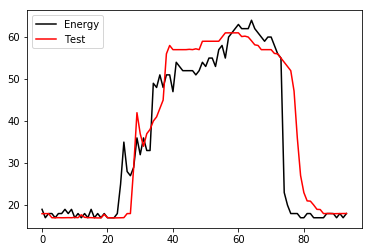

In [0]:
t = range(len(y_test[indxDay]))
plt.plot(t,y_test[indxDay],'k', label='Energy')
plt.plot(t,yhat[indxDay],'r', label='Test')
# plt.plot(t,yOriginal[indxDay],'b', label='Train')
plt.legend(loc='upper left')
plt.show()

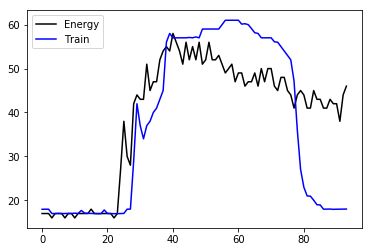

In [0]:
t = range(len(y_train[indxDay]))
plt.plot(t,y_train[indxDay],'k', label='Energy')
# plt.plot(t,yhat[indxDay],'r', label='Test')
plt.plot(t,yOriginal[indxDay],'b', label='Train')
plt.legend(loc='upper left')
plt.show()

In [0]:
# epochModel1 = model1.history.epoch
historyModel1 = model1.history.history

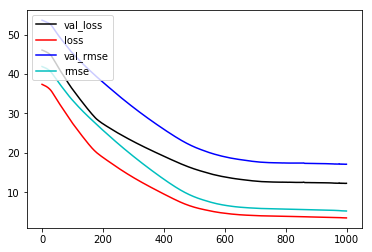

In [0]:
plt.plot(epochModel1,historyModel1["val_loss"],'k', label='val_loss')
plt.plot(epochModel1,historyModel1["loss"],'r', label='loss')
plt.plot(epochModel1,historyModel1["val_rmse"],'b', label='val_rmse')
plt.plot(epochModel1,historyModel1["rmse"],'c', label='rmse')
plt.legend(loc='upper left')
plt.show()

In [0]:
import pandas as pd

def minmax_time_df(df_, return_df=True):
  """
  Returns the time boundaries of the DataFrames DatetimeIndex.
  :param pd.DataFrame df_: pandas DataFrame with DatetimeIndex
  :param bool return_df: if the return is a DataFrame or a Tuple of Timestamps.
  :return:
  """
  if return_df:
    return pd.Series(df_.index).agg(['min', 'max'])
  else:
    return df_.index.min(), df_.index.max()

def gen_complete_timerange(df_, freq_):
  """
  Generates a timeseries from the min and max of the df_index, with the same frequency.
  :param df_: dataframe with the timestamp on the index
  :param freq_: frequency of the index
  :return: pd.DatetimeIndex
  """
  # freq_='1min'
  # df_ = mastertable_real_df
  # test_ind_mockdf = pd.Series([1]*df_.index.size, index=df_.index)
  # test_ind_df = test_ind_mockdf.resample(freq_).first().dropna()
  tmin, tmax = minmax_time_df(df_, return_df=False)
  timerange_minmax = pd.date_range(tmin, tmax, freq=freq_)
  return timerange_minmax

def gen_missing_timerange(df_, freq_):
  """
  Generates a timeseries from the min and max of the df_index, with the same frequency, and returns only the
      timepoints missing in the original.
  :param df_ pd.DataFrame: dataframe with the timestamp on the index
  :param freq_ str: frequency of the index
  :return: pd.DatetimeIndex
  """
  timerange_minmax = gen_complete_timerange(df_, freq_)
  timerange_missing = timerange_minmax[~timerange_minmax.isin(df_.index)]
  
  return timerange_missing
